---

<h1><center></center></h1>

<b><h1><center>Options Implied Probability Density Function</center></h1></b>

<i><center>[*Carl Somers*](https://www.linkedin.com/in/carl-somers-2a6104207/)</center></i>

---
Extracting the markets expecations for the future using options. This is just a test to see what the SPY options market has priced probability-wise for the January 2024 Federal Reserve Meeting (31/01/24). 

In [24]:
# Load in some pre-requisite libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
from pandas_market_calendars import get_calendar
import os
from datetime import datetime

# ignore all warnings
warnings.filterwarnings('ignore')

# Preferences 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['figure.dpi'] = 600
plt.rcParams.update({'font.size': 10})

# to do inline plots in the Notebook
%matplotlib inline

In [25]:
path_pattern = 'options_data/Old/{}.csv'

dates = ['30-01-2024', '31-01-2024']

calls_dirty = {}
puts_dirty = {}

for date in dates:
    call_path = path_pattern.format(f'calls_{date}')
    put_path = path_pattern.format(f'puts_{date}')

    calls_dirty[date] = pd.read_csv(call_path)
    puts_dirty[date] = pd.read_csv(put_path)

In [26]:
# Stored both puts and calls in a dictionary of dataframes keys are expirations
print(f"{calls_dirty.keys()} \n\nSample: \n")

dt = "30-01-2024"
calls_dirty[dt].head()

dict_keys(['30-01-2024', '31-01-2024']) 

Sample: 



,break_even_price,open_interest,details.contract_type,details.exercise_style,details.expiration_date,details.shares_per_contract,details.strike_price,details.ticker,last_quote.ask,last_quote.ask_size,...,last_trade.exchange,last_trade.timeframe,day.change,day.change_percent,day.previous_close,implied_volatility,greeks.delta,greeks.gamma,greeks.theta,greeks.vega
0,490.965,0,call,american,2024-01-30,100,406,O:SPY240130C00406000,85.16,305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,490.965,0,call,american,2024-01-30,100,407,O:SPY240130C00407000,84.16,305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,490.965,0,call,american,2024-01-30,100,408,O:SPY240130C00408000,83.16,305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,490.965,0,call,american,2024-01-30,100,409,O:SPY240130C00409000,82.16,305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,490.965,0,call,american,2024-01-30,100,410,O:SPY240130C00410000,81.16,305,...,308.0,REAL-TIME,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Cleaning**

In [68]:
calls, puts = {}, {}

for expiration in calls_dirty:
      calls[expiration] = calls_dirty[expiration][(calls_dirty[expiration]["details.strike_price"] >= 480) & (calls_dirty[expiration]["details.strike_price"] <= 500) &
                                            (calls_dirty[expiration]["last_quote.midpoint"] > 0) &
                                            (calls_dirty[expiration]["day.volume"] > 0) &
                                            (calls_dirty[expiration]["open_interest"] > 0)]
      puts[expiration] = puts_dirty[expiration][(puts_dirty[expiration]["details.strike_price"] >= 480) & (puts_dirty[expiration]["details.strike_price"] <= 500) &
                                          (puts_dirty[expiration]["last_quote.midpoint"] > 0) &
                                          (puts_dirty[expiration]["day.volume"] > 0) &
                                          (puts_dirty[expiration]["open_interest"] > 0)]

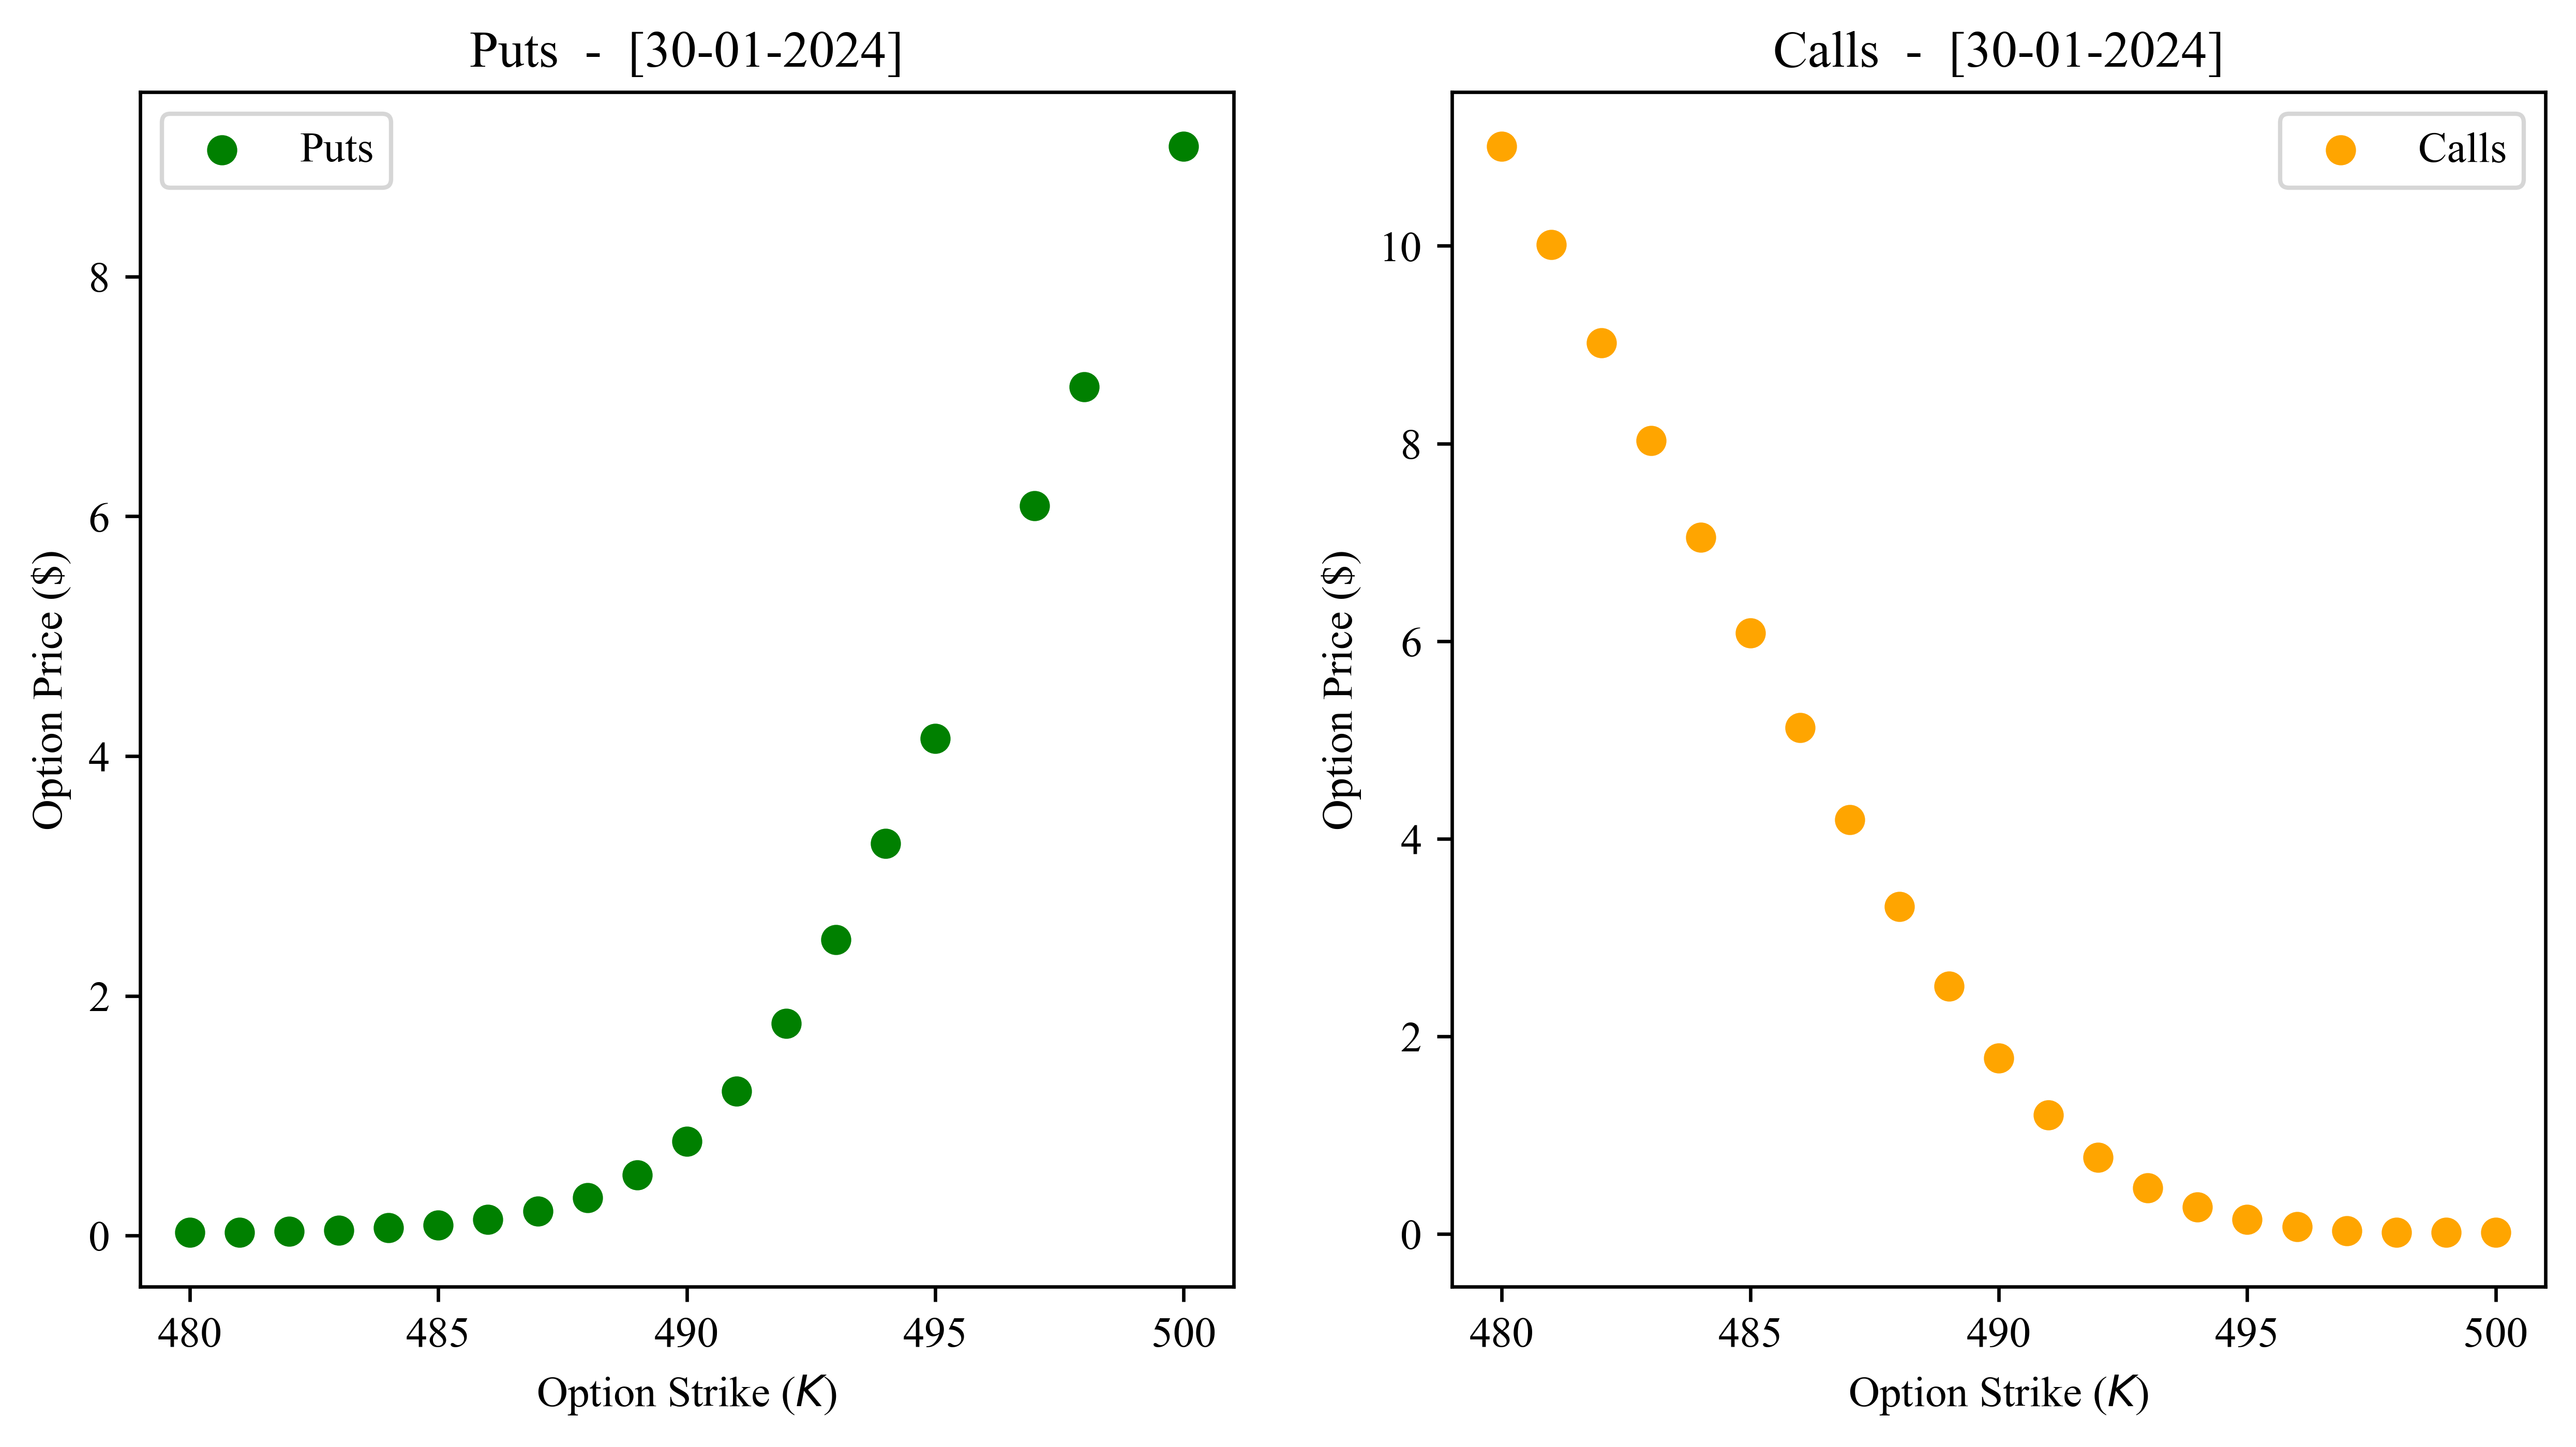

In [69]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

ax0.set_title(f"Puts  -  [{dt}]"); ax0.set_ylabel("Option Price ($)"); ax0.set_xlabel("Option Strike ($K$)");
ax0.scatter(puts[dt]["details.strike_price"], puts[dt]['last_quote.midpoint'], color = "g", label = "Puts");ax0.legend();

ax1.set_title(f"Calls  -  [{dt}]"); ax1.set_ylabel("Option Price ($)"); ax1.set_xlabel("Option Strike ($K$)");
ax1.scatter(calls[dt]["details.strike_price"], calls[dt]['last_quote.midpoint'], color = "orange", label = "Calls");ax1.legend();

plt.show()

In [70]:
_norm_cdf = scipy.stats.norm(0, 1).cdf
_norm_pdf = scipy.stats.norm(0, 1).pdf

def _d1(S, K, T, r, sigma):
    return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


def _d2(S, K, T, r, sigma):
    return _d1(S, K, T, r, sigma) - sigma * np.sqrt(T)


def call_value(S, K, T, r, sigma):
    """
    The fair value of a call option paying max(S-K, 0) at expiry, under the Black-scholes model,
    for an option with strike <K>, expiring in <T> years, under a fixed interest rate <r>,
    a stock volatility <sigma>, and when the current price of the underlying stock is <S>.
    """
    return S * _norm_cdf(_d1(S, K, T, r, sigma)) - K * np.exp(-r * T) * _norm_cdf(_d2(S, K, T, r, sigma))


def put_value(S, K, T, r, sigma):
    '''
    The fair value of a put option paying max(K-S, 0) at expiry, under the Black-scholes model,
    for an option with strike <K>, expiring in <T> years, under a fixed interest rate <r>,
    a stock volatility <sigma>, and when the current price of the underlying stock is <S>.
    '''
    return np.exp(-r * T) * K * _norm_cdf(-_d2(S, K, T, r, sigma)) - S * _norm_cdf(-_d1(S, K, T, r, sigma))


def vega(S, K, T, r, sigma):
    """
    Sensitivy of option to volatility
    """
    return S*np.sqrt(T)*_norm_pdf(_d1(S, K, T, r, sigma))

In [71]:
def IV_bs(P, S, K, T, flag, r = 0, iv_prior = 0.1, max_iter=1000):
    """
    Newton-Raphson Method
    Iteratively computes the IV inferred from the option price using the (inversed) black-scholes model
    Sigma (σ) = Implied Volatility (IV)

    P: market observed option price
    S: initial stock price
    K:  strike price
    T:  maturity
    r:  risk-free rate
    flag: option type
    iv_prior: IV a priori (guess)
    """
    sigma = iv_prior

    for _ in range(max_iter):
      if flag == "call":
        inferred_P = call_value(S, K, T, r, sigma)
      else:
        fv_put = put_value(S, K, T, r, sigma)
        inferred_P = put_call_parity_transform(fv_put, S, K, T, r, sigma)

      diff = P - inferred_P

      if abs(diff) < 1e-10:
        return sigma

      vega_ = vega(S, K, T, r, sigma)
      sigma += diff / vega_

    return sigma

In [72]:
paired_options = {}

for expiration, call_options in calls.items():
    combined_options = pd.concat([call_options, puts[expiration]], axis=0).sort_values(by="details.strike_price", ascending=True).fillna(0)
    
    paired_options[expiration] = (combined_options[
        ((combined_options["details.contract_type"] == "call") & (combined_options['details.strike_price'] > combined_options['underlying_asset.price'])) |
        ((combined_options["details.contract_type"] == "put") & (combined_options['details.strike_price'] <= combined_options['underlying_asset.price']))
    ].dropna(subset=['details.strike_price']).reset_index(drop=True)
    .groupby('details.strike_price').apply(lambda group: group.head(1)).reset_index(drop=True))

paired_options[list(calls.keys())[0]].head()

,break_even_price,open_interest,details.contract_type,details.exercise_style,details.expiration_date,details.shares_per_contract,details.strike_price,details.ticker,last_quote.ask,last_quote.ask_size,...,last_trade.exchange,last_trade.timeframe,day.change,day.change_percent,day.previous_close,implied_volatility,greeks.delta,greeks.gamma,greeks.theta,greeks.vega
0,479.975,11095,put,american,2024-01-30,100,480,O:SPY240130P00480000,0.03,5314,...,308.0,REAL-TIME,-0.09,-75.0,0.12,0.189039,-0.013515,0.006747,-0.078943,0.013425
1,480.975,4153,put,american,2024-01-30,100,481,O:SPY240130P00481000,0.03,4272,...,303.0,REAL-TIME,-0.16,-84.2,0.19,0.173333,-0.014574,0.007828,-0.076941,0.013415
2,481.965,4746,put,american,2024-01-30,100,482,O:SPY240130P00482000,0.04,2580,...,312.0,REAL-TIME,-0.22,-84.6,0.26,0.165121,-0.020543,0.011001,-0.098033,0.013432
3,482.955,5106,put,american,2024-01-30,100,483,O:SPY240130P00483000,0.05,3942,...,302.0,REAL-TIME,-0.36,-90.0,0.40,0.156952,-0.027134,0.014809,-0.119127,0.013457
4,483.935,5939,put,american,2024-01-30,100,484,O:SPY240130P00484000,0.07,7524,...,301.0,REAL-TIME,-0.51,-89.5,0.57,0.148494,-0.039008,0.020936,-0.150520,0.026947


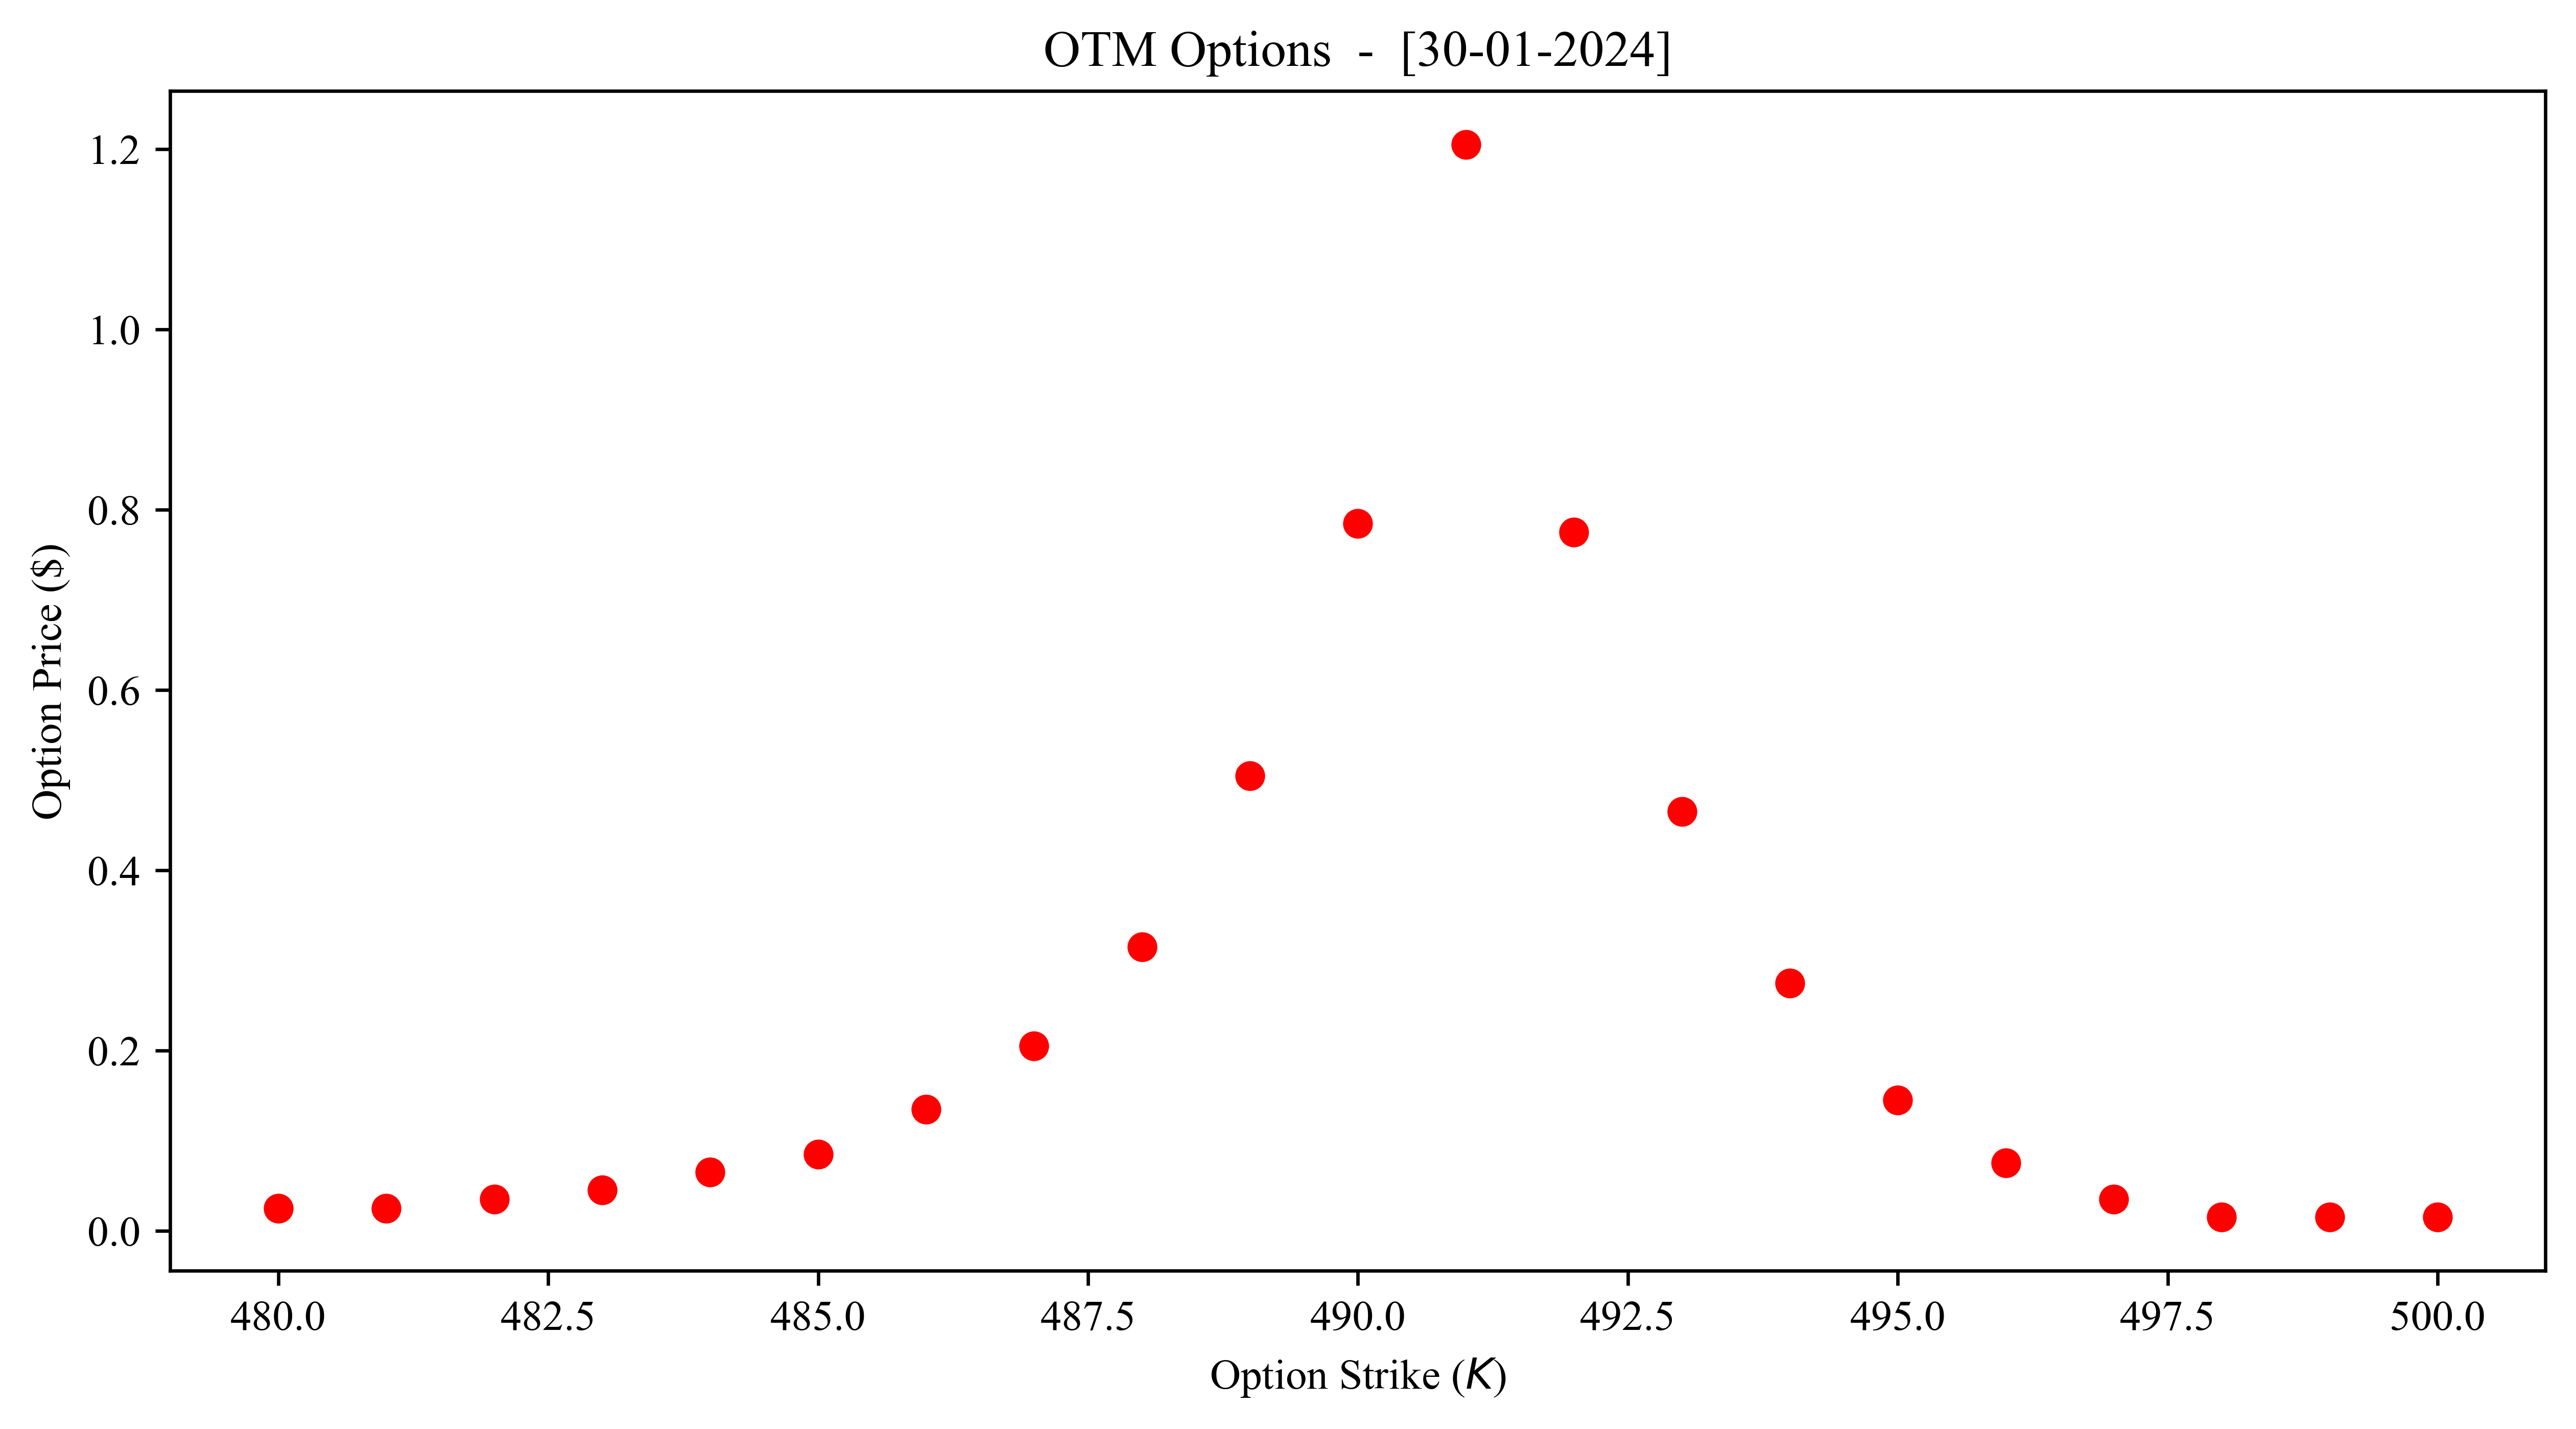

In [73]:
plt.figure(figsize=(10, 5))
plt.title(f"OTM Options  -  [{dt}]"); plt.ylabel("Option Price ($)"); plt.xlabel("Option Strike ($K$)");
plt.scatter(paired_options[dt]["details.strike_price"], paired_options[dt]['last_quote.midpoint'], color = "red", label = "OTM");

## **1. Non-Parametric PDF (Breeden-Litzenberger)**
These non-parametric methods are useful as we are not assuming an underlying distribution.

The Breeden-Litzenberger approach recovers the PDF from the second partial derivative of the call price ($C$) function with respect to the strike price.

$$\frac{\partial^2 C}{\partial K^2} = e^{-rT} f(S_T)$$

Where $K$ is the strike price, $e^{-rT}$ is the discount factor, $e^{rT}S_t$ the forward price of the asset to expiry, therefore, $f(S_T)$ is the (risk-neutral implied) PDF.

In reality, the strikes are discrete (seperate) but to get the PDF they must be continuous. To get this interpolation is applied across the smile. But due to the importance of option price (at each strike) simple interpolation could result in drastic mispricing.

Shimko (1993) suggests using the Black-Scholes model to interpolate in the IV space rather than the price space. I.e interpolate the values of the pricing model rather than the price output itself.


### **1.1 Black-Scholes**

$$C(S, r) = e^{-rT} C(e^{rT}S, 0)$$

We can immediately see a problem. This model is for call options. Therefore, we must use Put-Call Parity to transform our puts into calls.

In [74]:
def put_call_parity_transform(P, S, K, T, r, sigma):
    """
    Transform a put option value to a call option value using put-call parity.
    """
    return P + S - K * np.exp(-r * T)

Now we are able to focus on strictly OTM liquid options

In [75]:
exclusions = []

calendar = get_calendar("NYSE")

# 10-year treasury bill on 29/01/24
t_bill = 0.052100000381469724

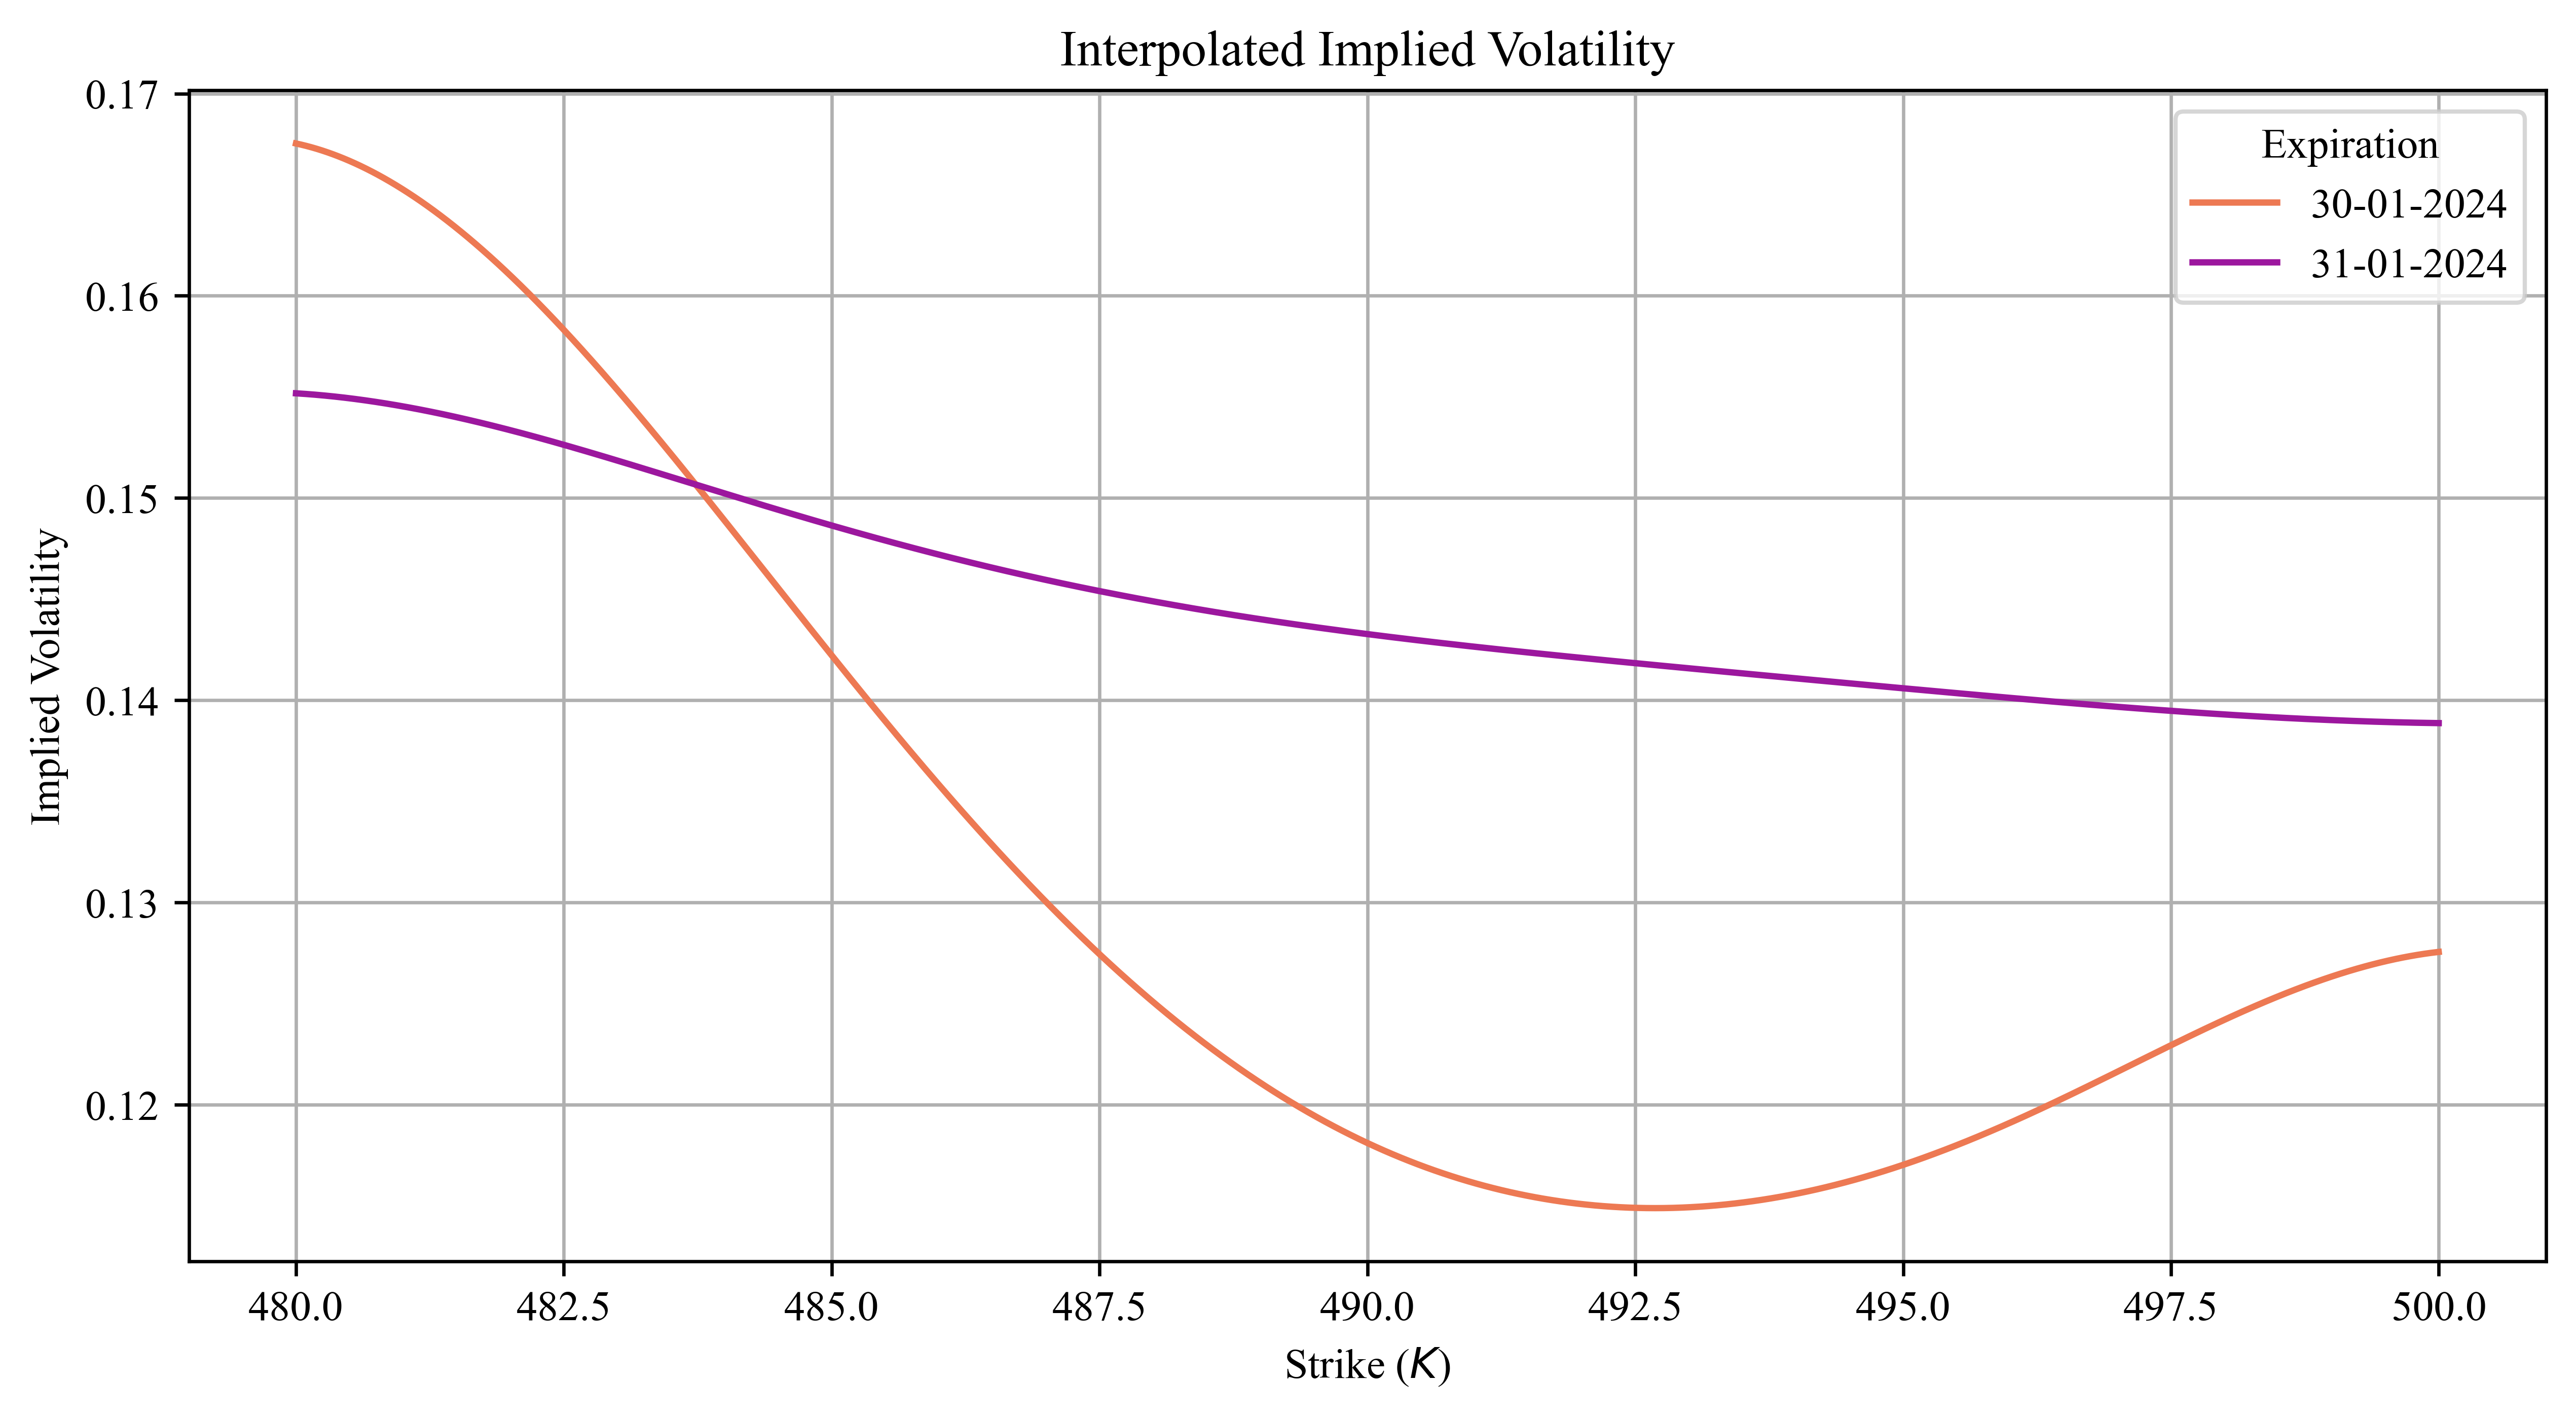

In [90]:
palette = sns.color_palette("plasma_r", len(calls.keys()))

plt.figure(figsize = (10,5))

interpolated_otm = {}

for i, expiration in enumerate(calls.keys()):
    if expiration not in exclusions:
        T = (calendar.valid_days(datetime.today(), pd.to_datetime(paired_options[expiration]["details.expiration_date"].iloc[0])).size) / 252
    
        IVs = paired_options[expiration]["implied_volatility"].values
        Ks = paired_options[expiration]["details.strike_price"].values
        
        # Add Gaussian/Normal smoothing to the probability
        smooth_ivs = scipy.ndimage.gaussian_filter1d(IVs, 3)
        vol_space = scipy.interpolate.interp1d(Ks, smooth_ivs, kind="cubic", fill_value="extrapolate")
        new_K = np.arange(min(Ks), max(Ks), 0.001)  # interpolate to more intricate strikes
        plt.plot(new_K, vol_space(new_K), label=expiration, color = palette[i])
    
        # Save
        interpolated_otm[expiration] = {"strike_prices": new_K, "smoothed_iv_values": vol_space(new_K)}

plt.title('Interpolated Implied Volatility')
plt.xlabel('Strike ($K$)')
plt.ylabel('Implied Volatility')
plt.legend(title="Expiration", loc="best", ncol=1)
plt.grid(True)
plt.show()

In [87]:
iv_output = pd.DataFrame([
    {stat: getattr(scipy.stats.describe(interpolated_otm[expiration]["smoothed_iv_values"]), stat) for stat in ['mean', 'variance', 'skewness', 'kurtosis']}
    for expiration in interpolated_otm
])

iv_output.index = list(interpolated_otm.keys())

iv_output.columns = ['Mean', 'Standard Deviation', 'Skewness', 'Kurtosis']

round(iv_output, 3)

,Mean,Standard Deviation,Skewness,Kurtosis
30-01-2024,0.131,0.0,0.953,-0.503
31-01-2024,0.145,0.0,0.666,-0.853


### **1.2 Breeden-Litzenberger**

$$\frac{\partial^2 C}{\partial K^2} = e^{-rT} f(S_T)$$

From the formula we can see we need to take the 2nd derivative of our new smooth option cost with respect to the new micro-level strikes.

**Price Space**

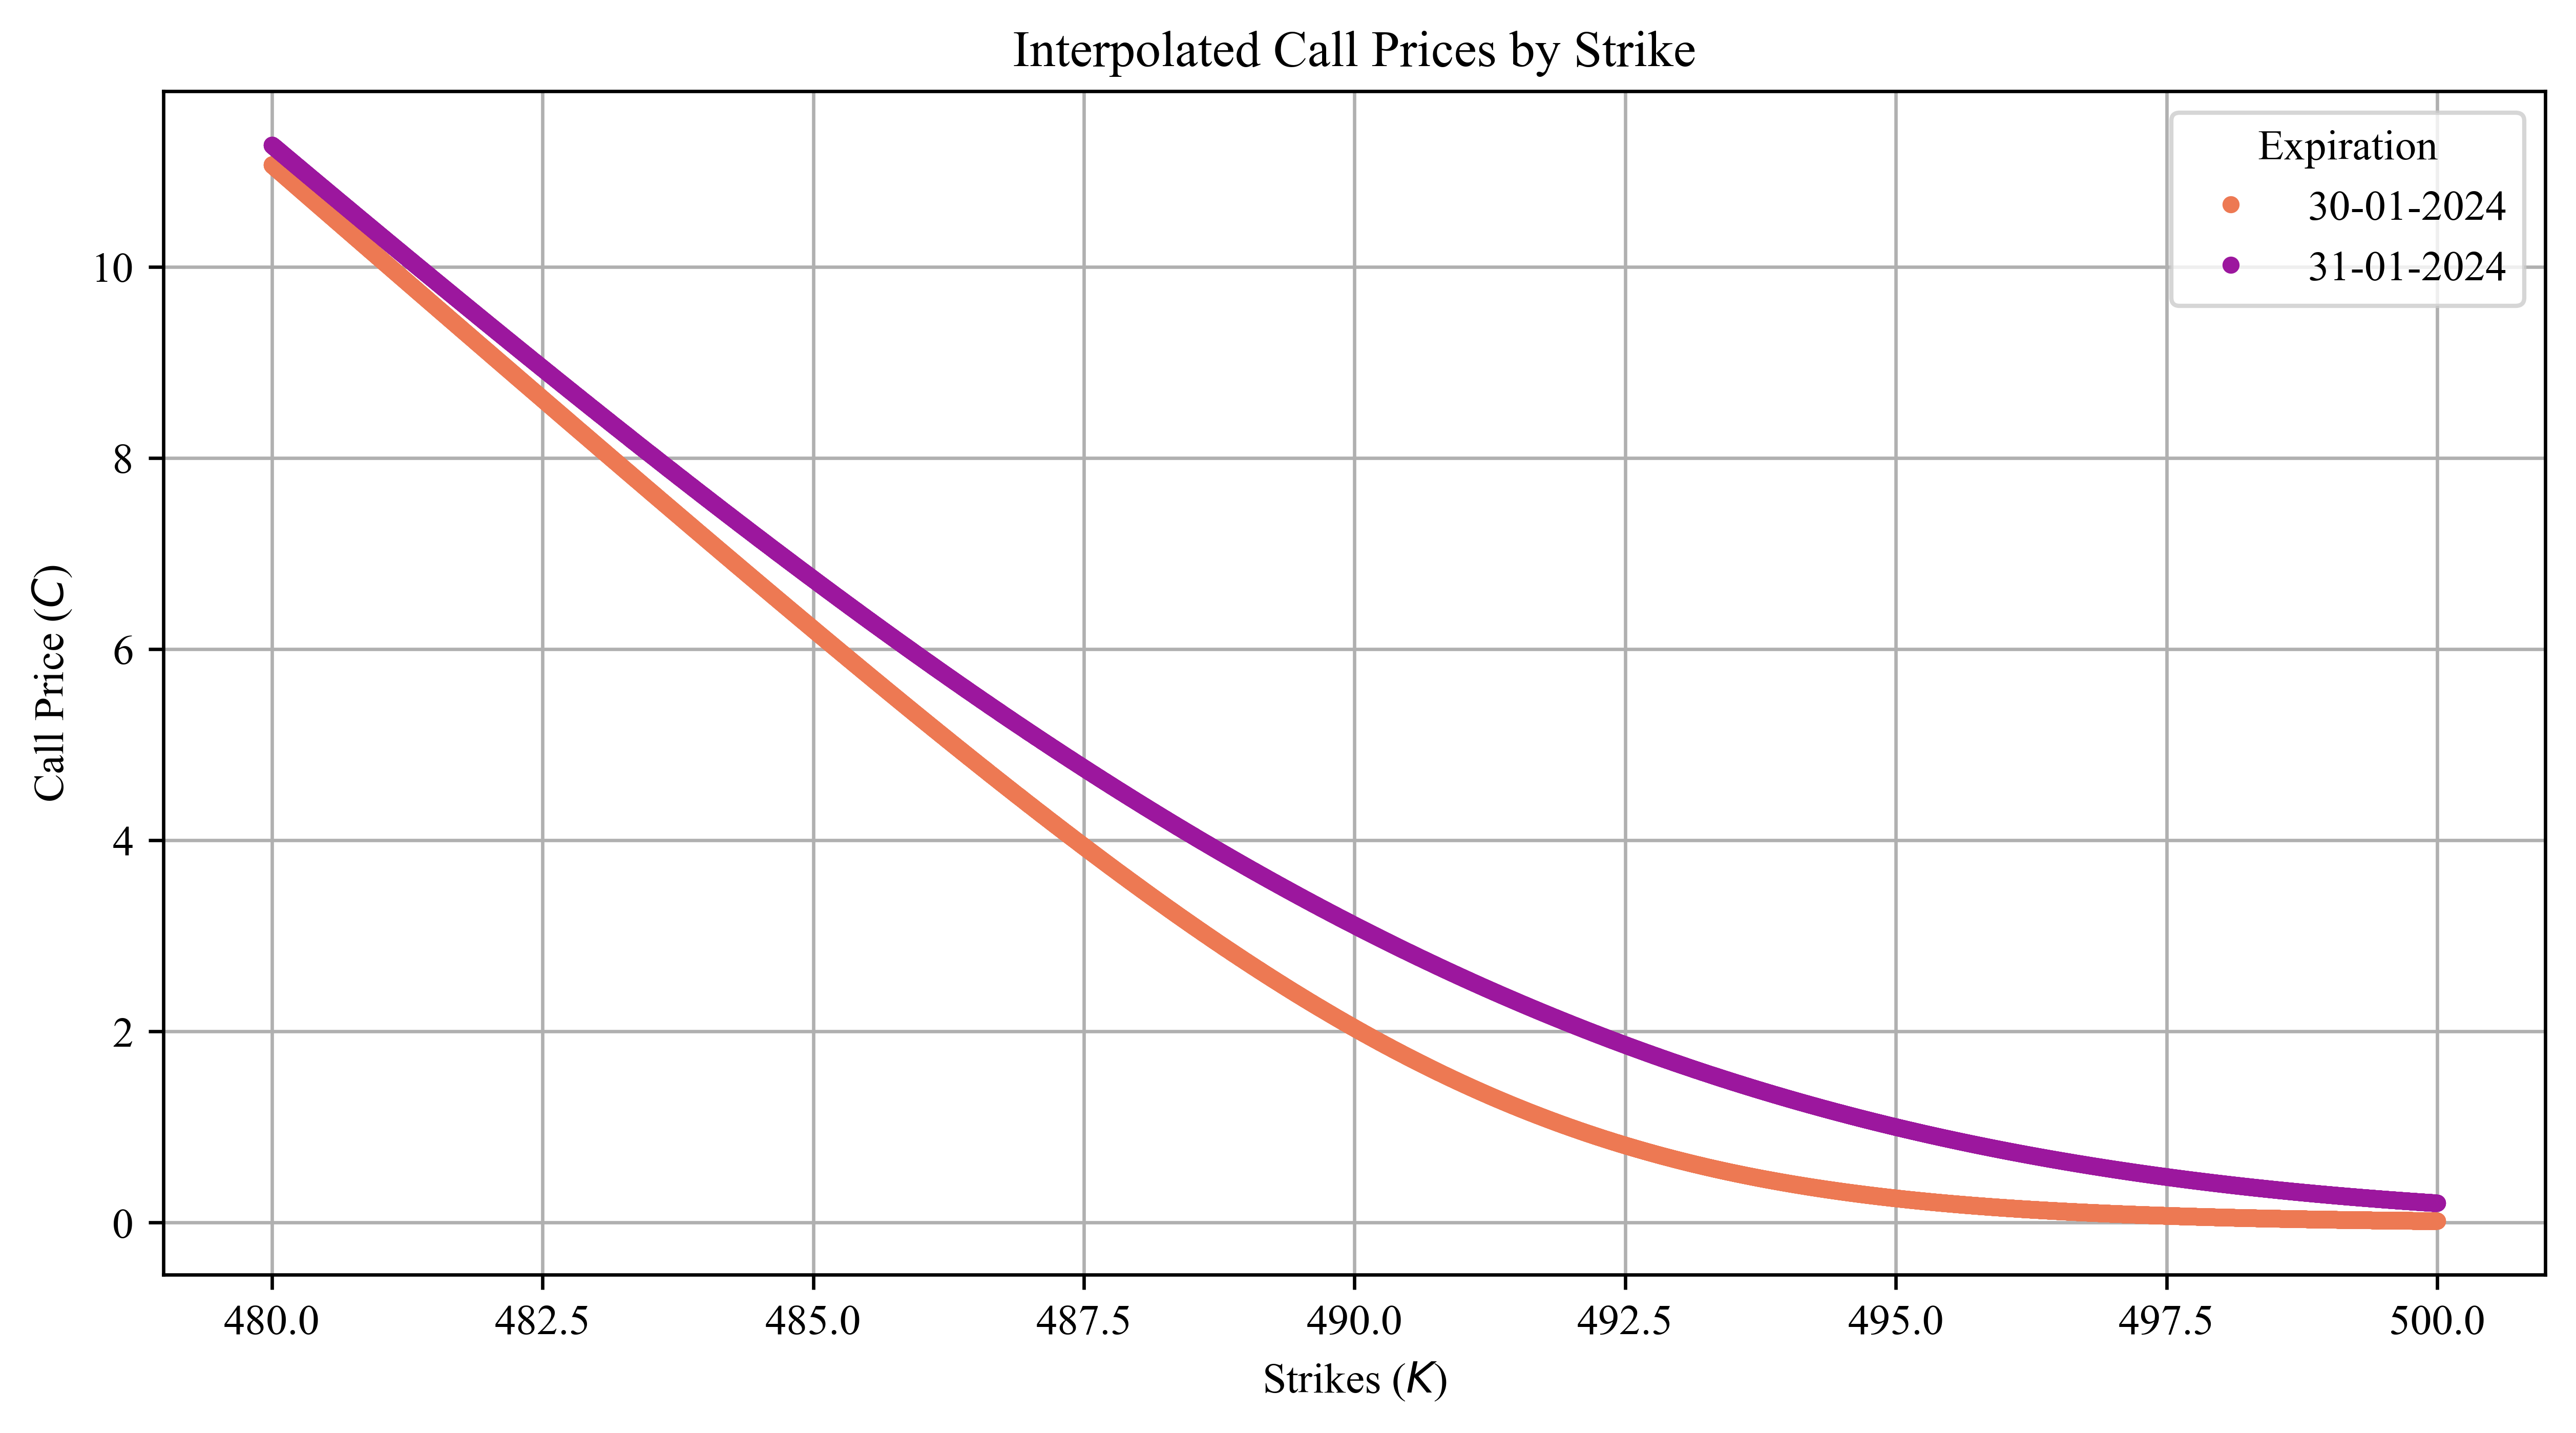

In [78]:
plt.figure(figsize=(10, 5))

for i, expiration in enumerate(calls.keys()):
    if expiration not in exclusions:
        T = (calendar.valid_days(pd.to_datetime(calls[expiration]['last_trade.sip_timestamp'].iloc[0]), 
                                 pd.to_datetime(calls[expiration]["details.expiration_date"].iloc[0])).size-1) / 252
    
        S = calls[expiration]['underlying_asset.price'].iloc[0]
        strike_prices = interpolated_otm[expiration]["strike_prices"]
        smoothed_iv_values = interpolated_otm[expiration]["smoothed_iv_values"]
        
        # Calculate call prices using the Black-Scholes formula
        call_prices = [call_value(S=S, K=K, T=T, r=t_bill, sigma=sigma) for K, sigma in zip(strike_prices, smoothed_iv_values)]
    
        # Plot the results for each expiration with the same color as before
        plt.plot(strike_prices, call_prices, ".", label=expiration, color=palette[i])
    
        # Save call prices in the dictionary
        interpolated_otm[expiration]["call_prices"] = call_prices

plt.title("Interpolated Call Prices by Strike")
plt.xlabel("Strikes ($K$)")
plt.ylabel("Call Price ($C$)")
plt.legend(title="Expiration")
plt.grid(True)
plt.show()

**Cumulative Probability Function (CDF)**

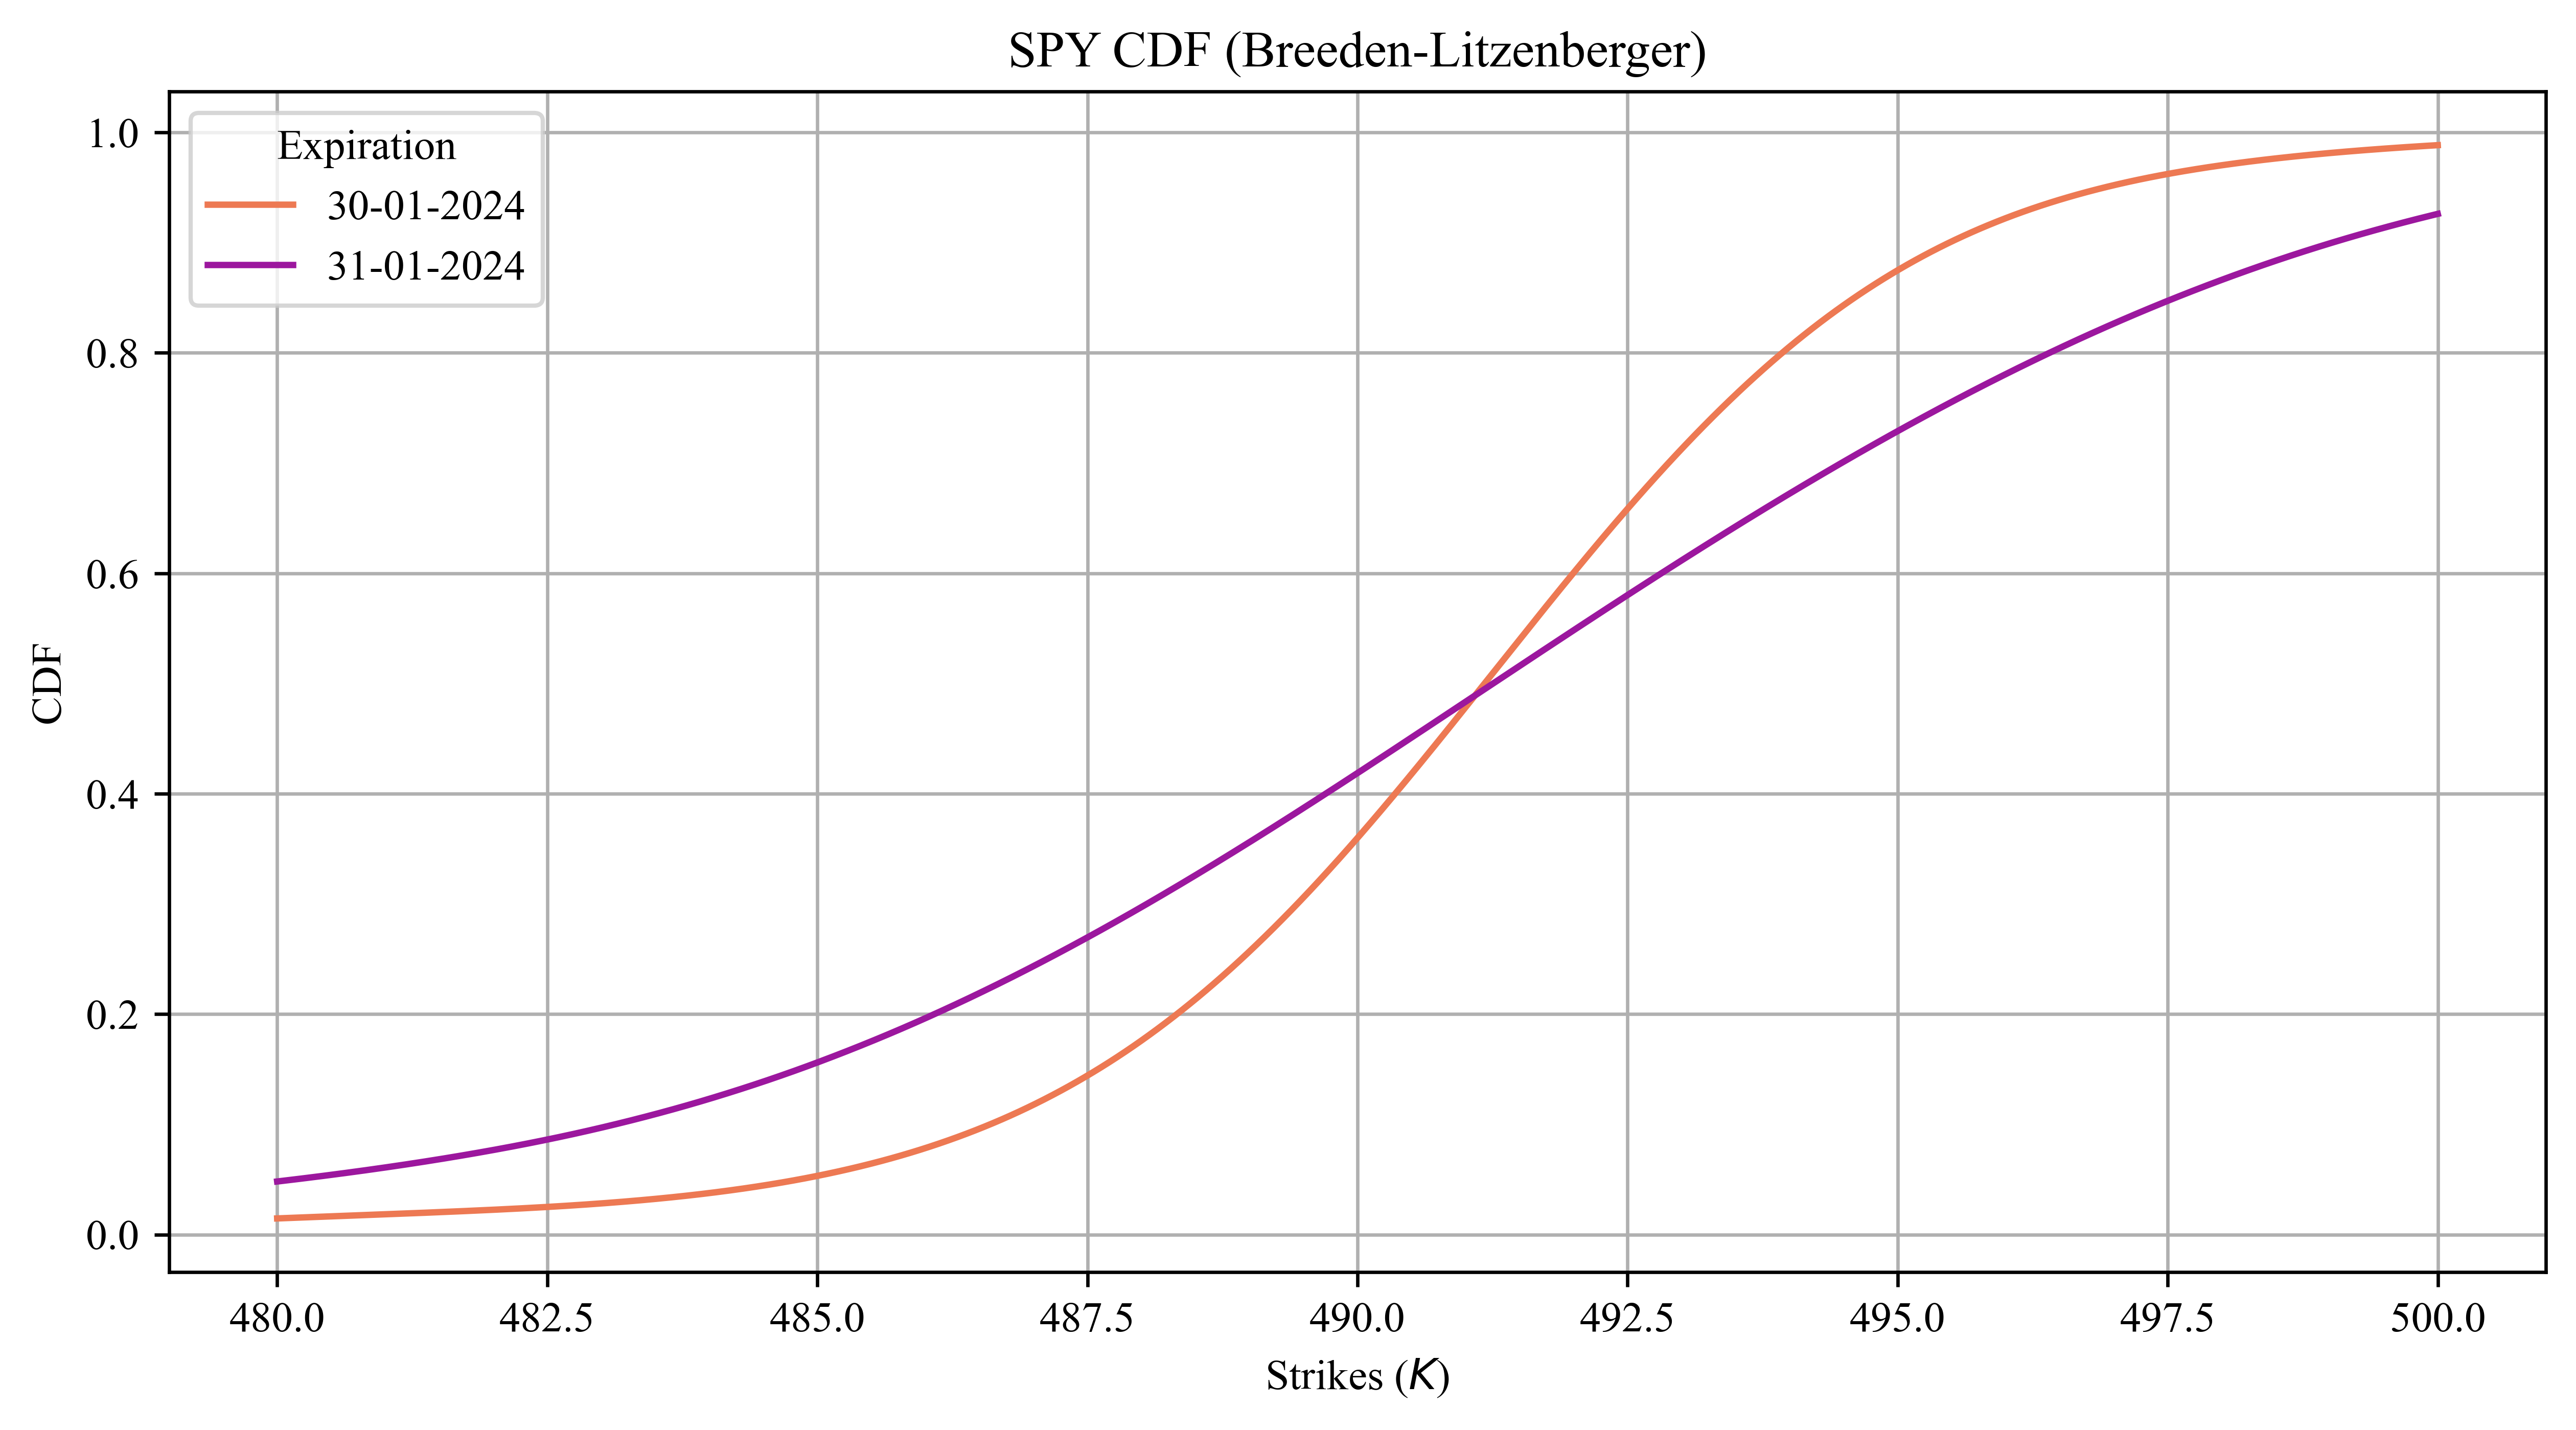

In [79]:
plt.figure(figsize=(10, 5))

for i, expiration in enumerate(calls.keys()):
    if expiration not in exclusions:
        smoothed_K = interpolated_otm[expiration]["strike_prices"]
        C = interpolated_otm[expiration]["call_prices"]
        
        d1_c = np.gradient(C, smoothed_K, edge_order=0)
        plt.plot(smoothed_K, 1+d1_c, label=expiration, color=palette[i])
    
        interpolated_otm[expiration]["cdf"] = d1_c

plt.title("SPY CDF (Breeden-Litzenberger)")
plt.xlabel("Strikes ($K$)")
plt.ylabel("CDF")
plt.legend(title = "Expiration")
plt.grid(True)
plt.show()

**Probability Density Function (PDF)**

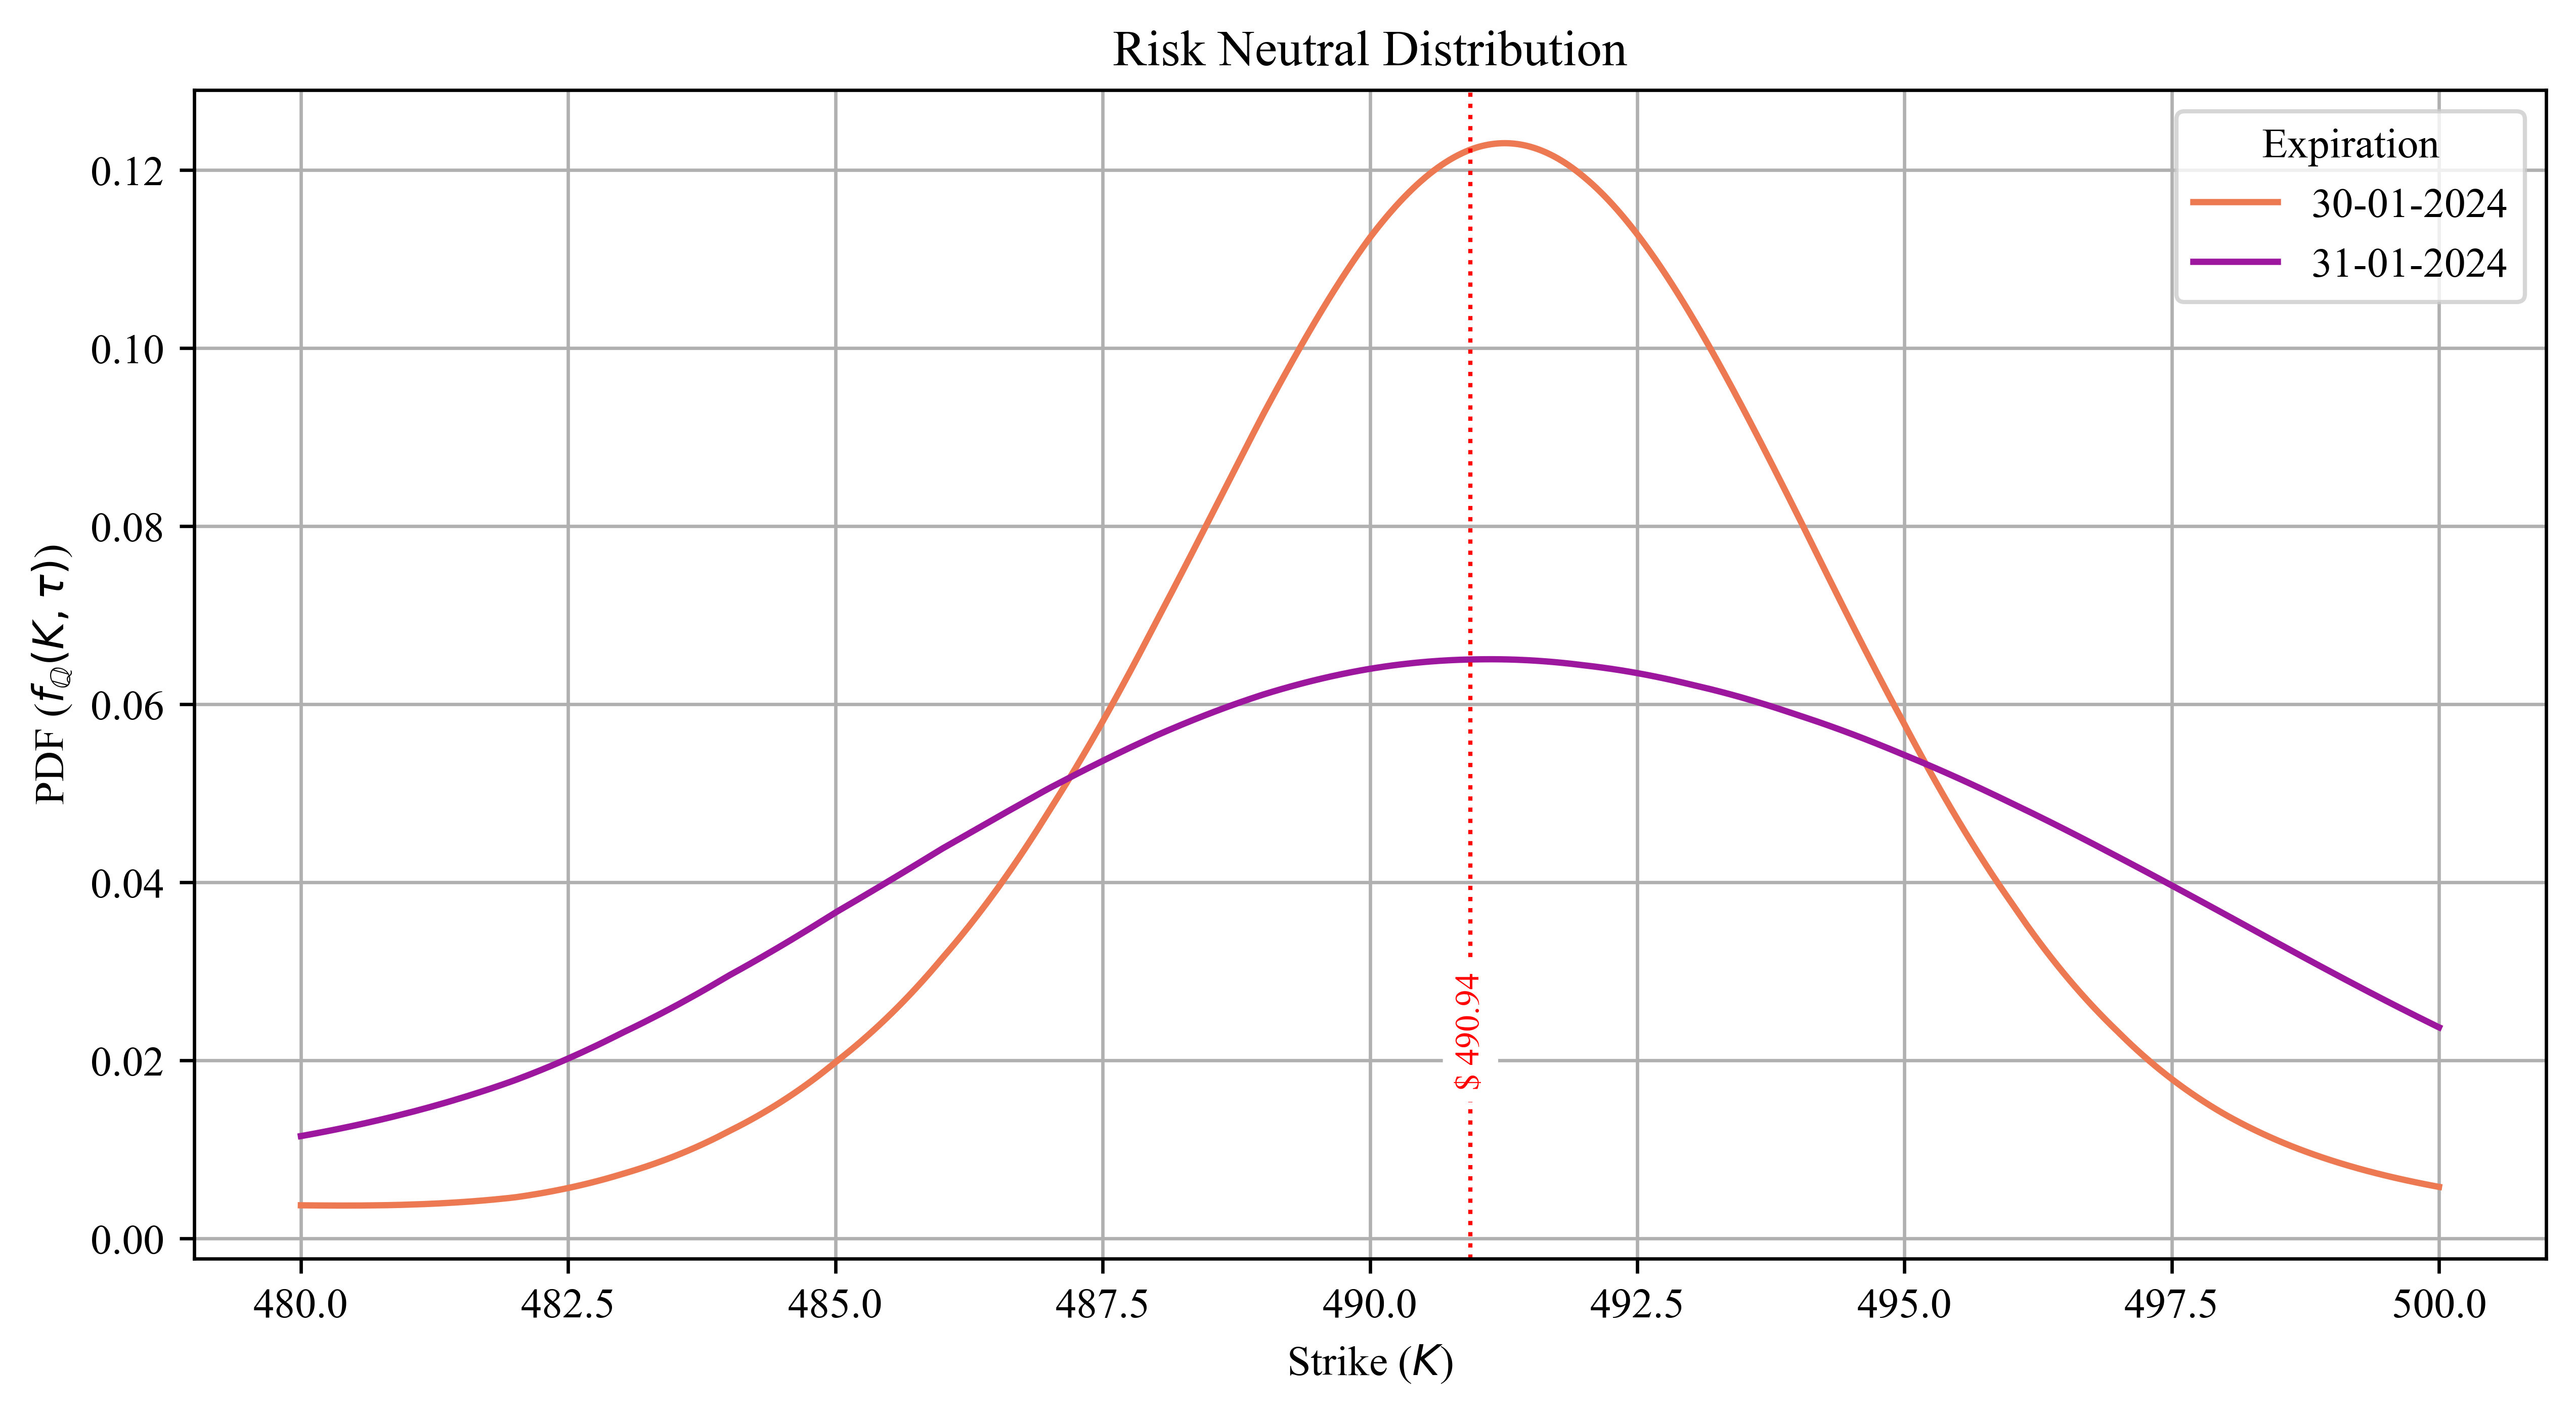

In [80]:
plt.figure(figsize=(10, 5))

for i, expiration in enumerate(calls.keys()):
    if expiration not in exclusions:
        smoothed_K = interpolated_otm[expiration]["strike_prices"]
        cdf = interpolated_otm[expiration]["cdf"]
    
        d2_c = np.gradient(cdf, smoothed_K, edge_order=0)
        
        interpolated_otm[expiration]["pdf"] = d2_c

        plt.plot(smoothed_K, d2_c, label=expiration, color=palette[i])

plt.axvline(x= calls[dt]['underlying_asset.price'].iloc[0], color="r", linestyle=":", linewidth=1)
plt.annotate(f"$ {calls[dt]['underlying_asset.price'].iloc[0]:.2f}",xy=(calls[dt]['underlying_asset.price'].iloc[0], min(d2_c)),xytext=(0, 25), textcoords="offset points",
            ha='center', va='center', color='r', fontsize=8, rotation="vertical",
            bbox=dict(boxstyle='round', color='white'))

plt.title("Risk Neutral Distribution")
plt.xlabel("Strike ($K$)")
plt.ylabel("PDF ($f_{\\mathbb{Q}}(K, \\tau)$)")
plt.legend(title = "Expiration")
plt.grid(True)
plt.show()

In [81]:
pdf_output = pd.DataFrame([
    {stat: getattr(scipy.stats.describe(interpolated_otm[expiration]["pdf"]), stat) for stat in ['mean', 'variance', 'skewness', 'kurtosis']}
    for expiration in interpolated_otm
])

pdf_output.index = list(interpolated_otm.keys())

pdf_output.columns = ['Mean', 'Standard Deviation', 'Skewness', 'Kurtosis']

round(pdf_output, 3)

,Mean,Standard Deviation,Skewness,Kurtosis
30-01-2024,0.049,0.002,0.537,-1.223
31-01-2024,0.044,0.000,-0.371,-1.170


**Breeden-Litzenberger**

Price to PDF

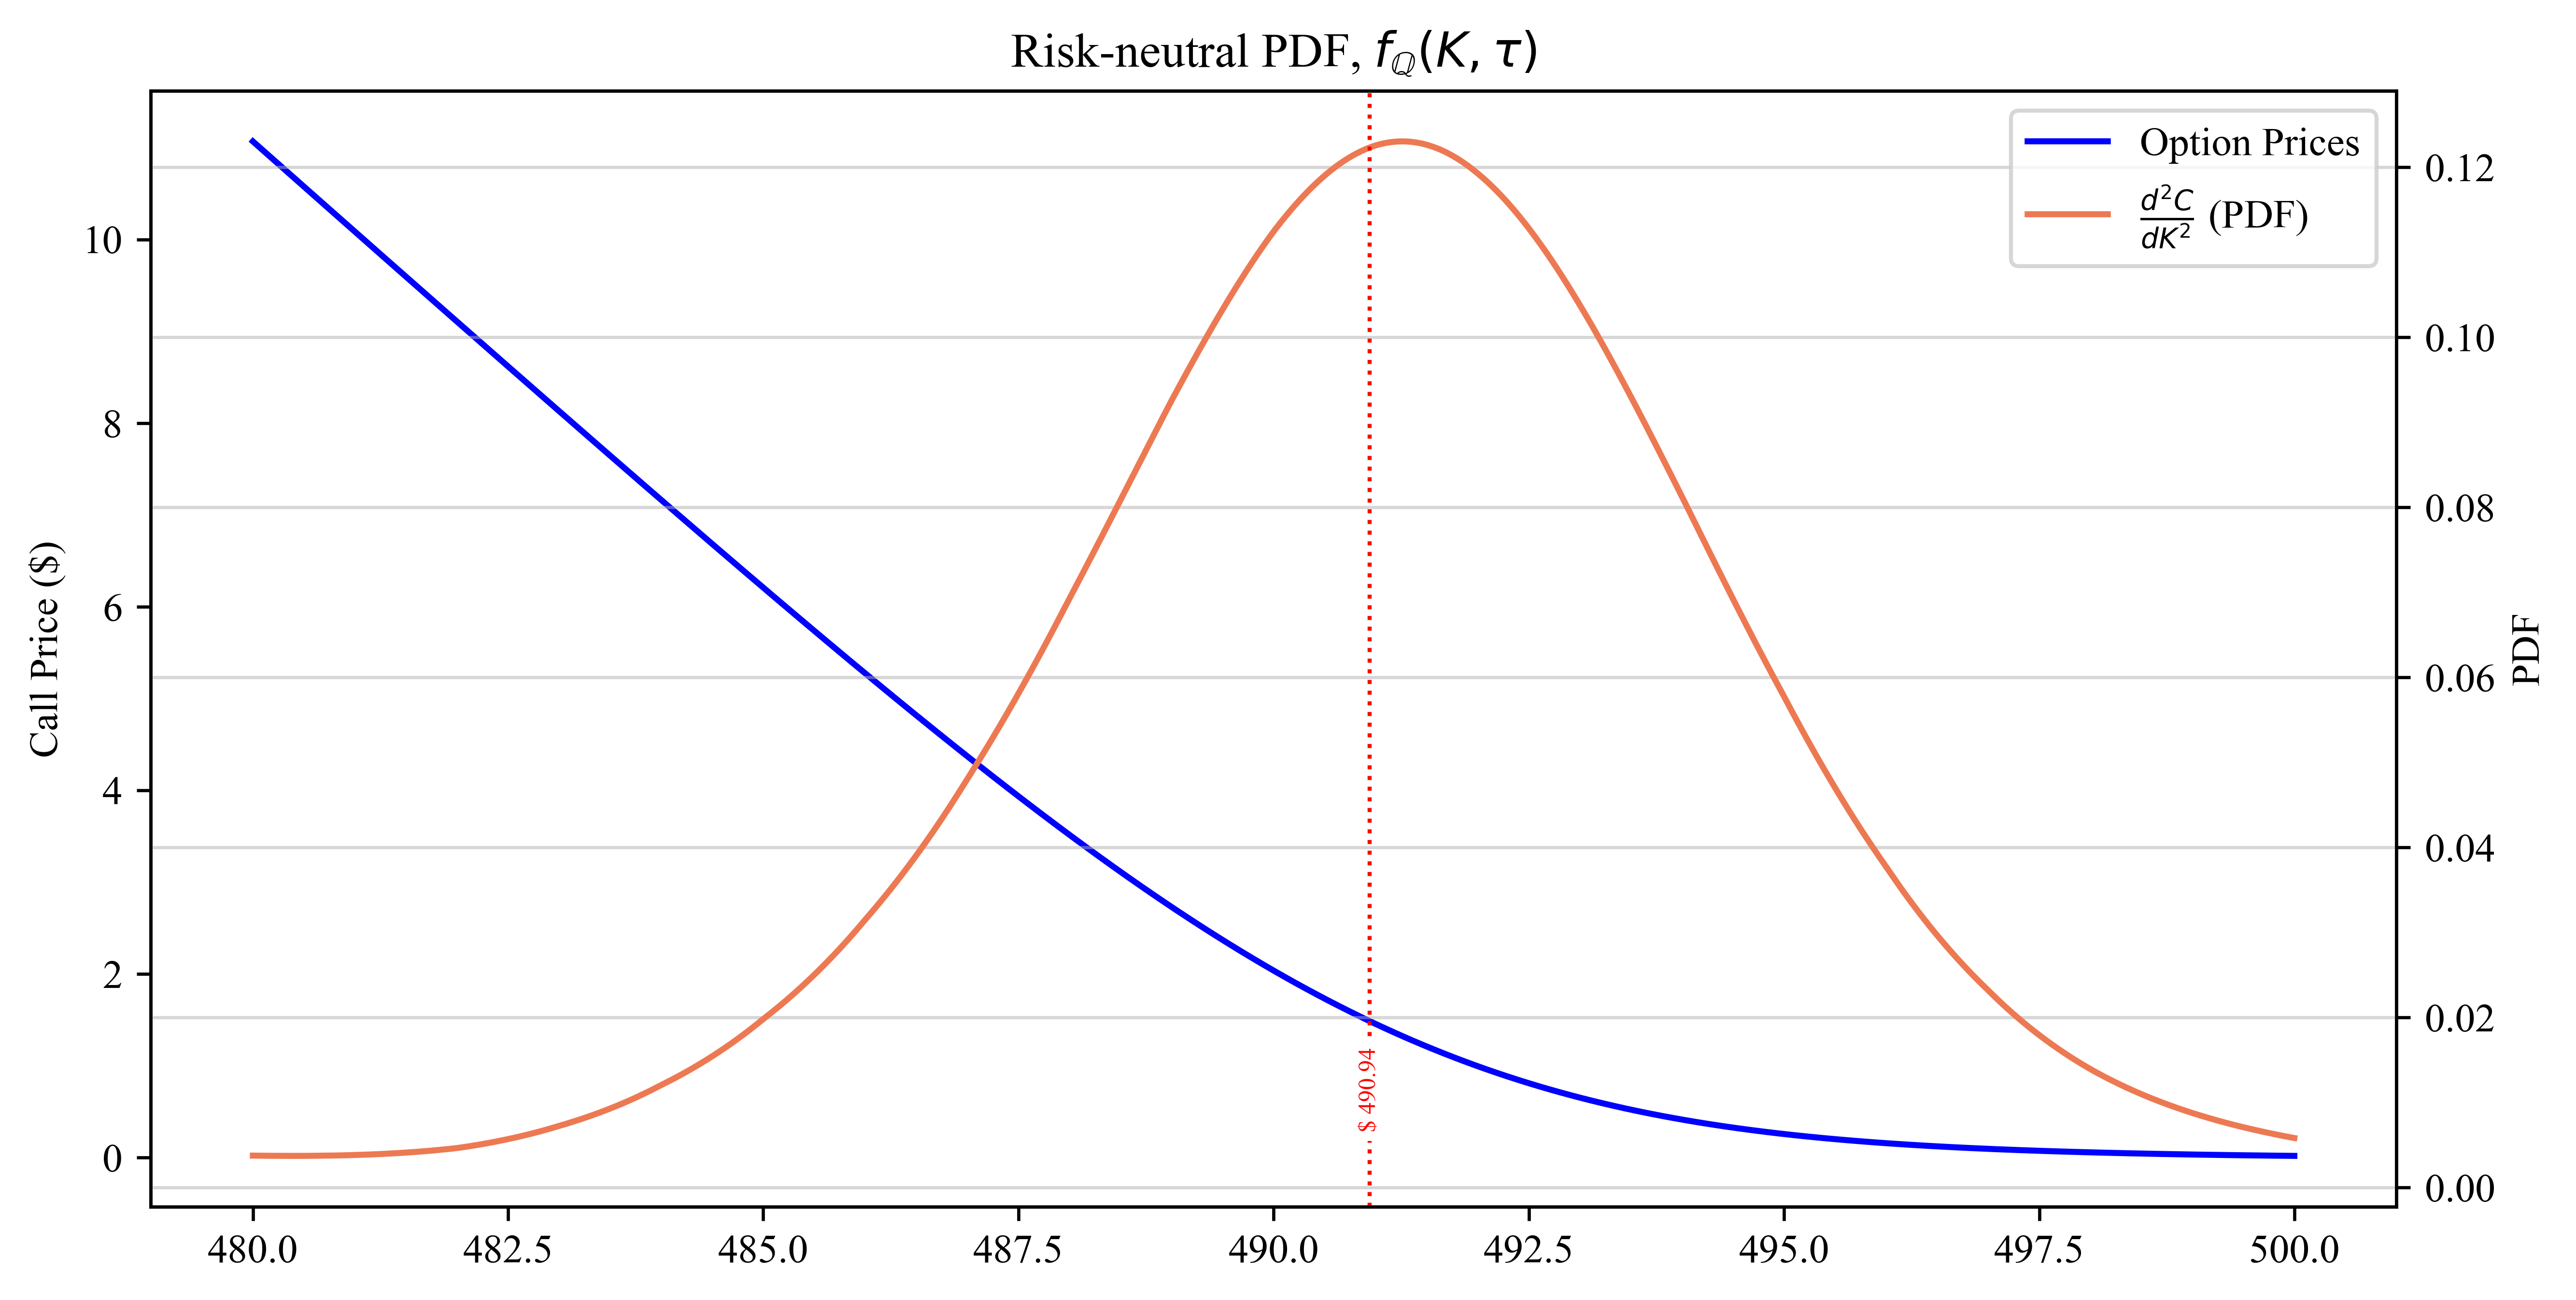

In [82]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.ylabel('Call Price ($)')

dt = "30-01-2024"

ax.plot(interpolated_otm[dt]["strike_prices"],
        interpolated_otm[dt]["call_prices"],
        label='Option Prices',
        color='blue');ax.set_ylabel('Call Price ($)')

ax2 = ax.twinx()
ax2.plot(interpolated_otm[dt]["strike_prices"],
         interpolated_otm[dt]["pdf"],
         label='$\\frac{d^2C}{dK^2}$ (PDF)',
         color=palette[0]);ax2.set_ylabel('PDF')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.axvline(x= calls[dt]['underlying_asset.price'].iloc[0], color="r", linestyle=":", linewidth=1)
plt.annotate(f"$ {calls[dt]['underlying_asset.price'].iloc[0]:.2f}",
             xy=(calls[dt]['underlying_asset.price'].iloc[0], min(d2_c)),
             xytext=(0, 0), textcoords="offset points",
             ha='center', va='center', color='r', fontsize=6, rotation="vertical",
             bbox=dict(boxstyle='round', color='white'))

plt.grid(True, alpha = 0.5)
plt.xlabel('Strikes (K)')
plt.title('Risk-neutral PDF, $f_{\\mathbb{Q}}(K, \\tau)$')

plt.show()